In [15]:
# Dans Anaconda Prompt : mlflow ui

import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, f1_score
from collections import Counter
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

2025/07/02 13:32:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/02 13:32:52 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: AttributeError("'int' object has no attribute 'lower'"). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


F1-score (micro): 0.5755395683453237
F1-score (samples): 0.5043478260869564


Registered model 'TagPredictionModel' already exists. Creating a new version of this model...
Created version '6' of model 'TagPredictionModel'.


 Run enregistré : file:///C:/Mes documents/OpenClassRooms/PROJET5/mlruns/451208790809575449/3097993e7d2248a4a56540a339f705fd/artifacts
 Run ID : 3097993e7d2248a4a56540a339f705fd
 Exemple de prédiction pour : 'how to create a generator in python' ➜ [('python',)]


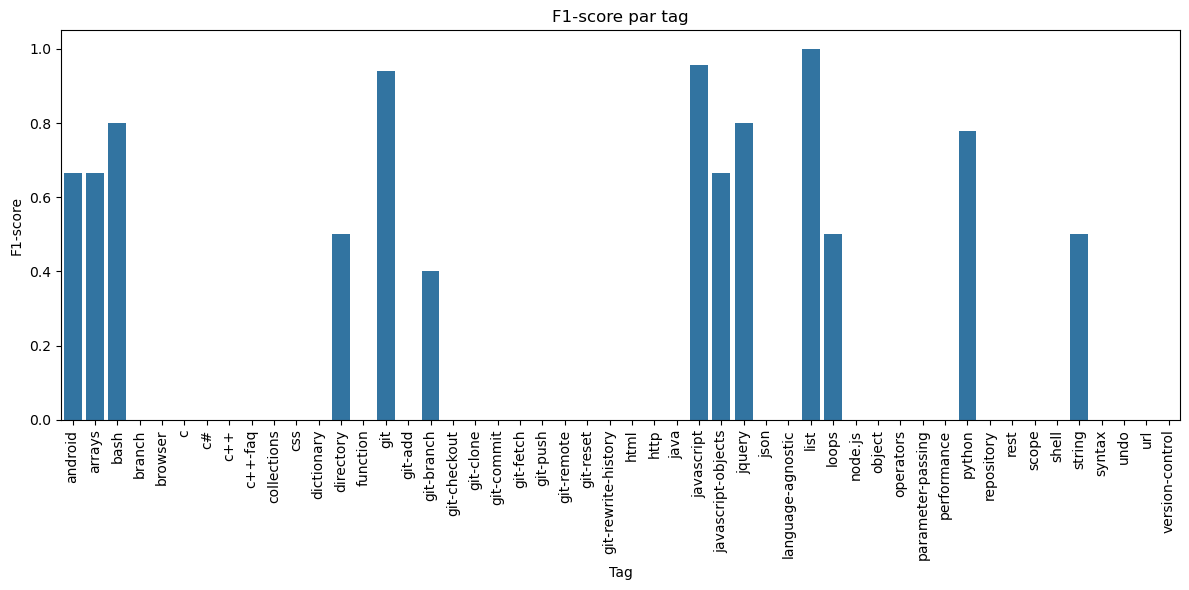

In [18]:
# 1. Chargement des données
df = pd.read_csv("stack_questions_api.csv")

# 2. Nettoyage des titres (non-cleané)
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

# Application sur les titres
df['clean_title'] = df['title'].astype(str).apply(clean_text)
df['tags'] = df['tags'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# On ne garde que les 50 tags les plus fréquents
all_tags = [tag for tags in df['tags'] for tag in tags]
top_tags = set([tag for tag, count in Counter(all_tags).most_common(50)])
df['tags'] = df['tags'].apply(lambda tags: [tag for tag in tags if tag in top_tags])
df = df[df['tags'].map(len) > 0]

# 3. Préparation des données
# Features (titres) et labels (tags binarisés)
X = df['clean_title']
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['tags'])

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Pipeline : TF-IDF + Classification
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', class_weight='balanced')))
])

# 5. Entraînement avec MLflow
mlflow.set_tracking_uri("file:///C:/Mes documents/OpenClassRooms/PROJET5/mlruns")
mlflow.set_experiment("Tag_Prediction_Improved")

# Entraînement + logging du modèle
with mlflow.start_run(run_name="LogReg_TFIDF_TopTags") as run:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_samples = f1_score(y_test, y_pred, average='samples')
    print("F1-score (micro):", f1_micro)
    print("F1-score (samples):", f1_samples)

    mlflow.log_metric("f1_micro", f1_micro)
    mlflow.log_metric("f1_samples", f1_samples)

    # 1. Log du modèle
    result = mlflow.sklearn.log_model(
        pipeline, 
        artifact_path="model",
        input_example=["how to create a generator in python"]
    )

    # 2. Enregistrement dans le Model Registry (si jamais il n'existe pas déjà)
    mlflow.register_model(result.model_uri, "TagPredictionModel")

    # 3. Sauvegarde et log du MultiLabelBinarizer
    joblib.dump(mlb, "mlb.pkl")
    mlflow.log_artifact("mlb.pkl")

    print(f" Run enregistré : {mlflow.get_artifact_uri()}")
    print(f" Run ID : {run.info.run_id}")

# 6. Fonction de prédiction
def predict_tags(title):
    """
    Fonction de prédiction à partir d’un titre.
    Retourne une liste de tags.
    """
    title = clean_text(title)
    tags_pred = pipeline.predict([title])
    return mlb.inverse_transform(tags_pred)

# Exemple
example = "how to create a generator in python"
print(f" Exemple de prédiction pour : '{example}' ➜ {predict_tags(example)}")

# 7. Visualisation
# Affichage du top tags et de leurs F1
report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True, zero_division=0)
f1_scores = {label: score['f1-score'] for label, score in report.items() if label in mlb.classes_}

plt.figure(figsize=(12, 6))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()))
plt.xticks(rotation=90)
plt.title("F1-score par tag")
plt.ylabel("F1-score")
plt.xlabel("Tag")
plt.tight_layout()
plt.show()

In [12]:
# Terminal: uvicorn app.main:app --reload
# http://127.0.0.1:8000/docs (interface Swagger interactive)